In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from scipy.stats import uniform, randint


In [2]:
dataset_path = r"..\..\datasets\petr4_options_data\processed_vale3_options.csv"
european_calls = pd.read_csv(dataset_path)
european_calls = european_calls[european_calls["type"] == "CALL"]
european_calls

,symbol,time,spot,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,variação
1,VALEK731,2022-11-14T00:00:00.000Z,"{'price': 83.31, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,69.84,14.05,EUROPEAN,3,ITM,0.904787,0.014246,0.015389,-0.340185,0.007301,130.739,87.83,14.0499,-0.0001
3,VALEL692,2022-11-22T00:00:00.000Z,"{'price': 80.14, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,65.91,15.46,EUROPEAN,18,ITM,0.867014,0.013827,0.046025,-0.097052,0.038588,72.559,82.08,15.4599,-0.0001
4,VALEG845,2022-11-24T00:00:00.000Z,"{'price': 81.45, 'symbol': 'VALE3'}",CALL,2023-07-21T00:00:00.000Z,81.16,12.80,EUROPEAN,171,ATM,0.592590,0.012618,0.260428,-0.037727,0.240665,45.847,44.30,12.7999,-0.0001
5,VALEL752,2022-11-28T00:00:00.000Z,"{'price': 81.3, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,71.91,10.38,EUROPEAN,13,ITM,0.844522,0.022495,0.044091,-0.102105,0.030065,57.483,81.13,10.3799,-0.0001
6,VALEL772,2022-11-17T00:00:00.000Z,"{'price': 83.1, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,73.91,9.96,EUROPEAN,21,ITM,0.868255,0.022960,0.051217,-0.052206,0.051826,38.763,84.29,9.9599,-0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6242,VALEK611,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,57.84,19.72,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.004589,0.011471,0.000,100.00,24.4829,4.7629
6243,VALEK493,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,49.34,28.19,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.003914,0.009786,0.000,100.00,32.9796,4.7896
6245,VALEK518,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,51.84,25.60,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.004113,0.010281,0.000,100.00,30.4806,4.8806
6254,VALEK718,2022-11-16T00:00:00.000Z,"{'price': 82.44, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,71.84,10.30,EUROPEAN,2,ITM,0.721802,0.012608,0.024646,-2.236221,0.003447,362.397,60.46,16.0758,5.7758


In [3]:
import ast

def extract_price(spot_value):
    try:
        parsed = ast.literal_eval(spot_value)  # Parse the string as a dictionary
        return parsed.get("price")  # Extract 'price'
    except (ValueError, SyntaxError, AttributeError):
        return None  # Return None if parsing fails

european_calls["spot_price"] = european_calls["spot"].apply(extract_price)

european_calls = european_calls[european_calls["type"] == "CALL"]
european_calls

,symbol,time,spot,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,variação,spot_price
1,VALEK731,2022-11-14T00:00:00.000Z,"{'price': 83.31, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,69.84,14.05,EUROPEAN,3,ITM,0.904787,0.014246,0.015389,-0.340185,0.007301,130.739,87.83,14.0499,-0.0001,83.31
3,VALEL692,2022-11-22T00:00:00.000Z,"{'price': 80.14, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,65.91,15.46,EUROPEAN,18,ITM,0.867014,0.013827,0.046025,-0.097052,0.038588,72.559,82.08,15.4599,-0.0001,80.14
4,VALEG845,2022-11-24T00:00:00.000Z,"{'price': 81.45, 'symbol': 'VALE3'}",CALL,2023-07-21T00:00:00.000Z,81.16,12.80,EUROPEAN,171,ATM,0.592590,0.012618,0.260428,-0.037727,0.240665,45.847,44.30,12.7999,-0.0001,81.45
5,VALEL752,2022-11-28T00:00:00.000Z,"{'price': 81.3, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,71.91,10.38,EUROPEAN,13,ITM,0.844522,0.022495,0.044091,-0.102105,0.030065,57.483,81.13,10.3799,-0.0001,81.30
6,VALEL772,2022-11-17T00:00:00.000Z,"{'price': 83.1, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,73.91,9.96,EUROPEAN,21,ITM,0.868255,0.022960,0.051217,-0.052206,0.051826,38.763,84.29,9.9599,-0.0001,83.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6242,VALEK611,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,57.84,19.72,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.004589,0.011471,0.000,100.00,24.4829,4.7629,82.30
6243,VALEK493,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,49.34,28.19,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.003914,0.009786,0.000,100.00,32.9796,4.7896,82.30
6245,VALEK518,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,51.84,25.60,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.004113,0.010281,0.000,100.00,30.4806,4.8806,82.30
6254,VALEK718,2022-11-16T00:00:00.000Z,"{'price': 82.44, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,71.84,10.30,EUROPEAN,2,ITM,0.721802,0.012608,0.024646,-2.236221,0.003447,362.397,60.46,16.0758,5.7758,82.44


### Selecting Relevant Columns, Scaling, Splitting, & performing XGBoost with Optuna (Bayesian Optim.)

In [4]:
european_calls.columns

Index(['symbol', 'time', 'spot', 'type', 'due_date', 'strike', 'premium',
       'maturity_type', 'days_to_maturity', 'moneyness', 'delta', 'gamma',
       'vega', 'theta', 'rho', 'volatility', 'poe', 'bs', 'variação',
       'spot_price'],
      dtype='object')

In [5]:
data = european_calls
# Here, I perform stratified split, as it is important to keep the proportions of ITM, OTM, ATM
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in stratified_split.split(data, data['moneyness']):
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]

# Add Risk-Free Rate (constant for November 2022)
risk_free_rate = 0.1375  # Selic rate for Brazil in November 2022: https://g1.globo.com/economia/noticia/2022/08/03/copom-eleva-selic-para-1375percent-e-juro-basico-da-economia-chega-ao-maior-patamar-em-seis-anos.ghtml
train_data['RISK_FREE_RATE'] = risk_free_rate
test_data['RISK_FREE_RATE'] = risk_free_rate

# Handle outliers in PREMIUM by capping extreme values
price_upper_limit = train_data['premium'].quantile(0.99)
price_lower_limit = train_data['premium'].quantile(0.01)
train_data['premium'] = train_data['premium'].clip(lower=price_lower_limit, upper=price_upper_limit)


features = ['rho',
     'theta',
    'gamma',
    'spot_price',
    "strike",
    "days_to_maturity",
    "volatility",
            
]
target = 'premium'

# Drop MONEYNESS_CATEGORY (it is a string)
train_data = train_data.drop(columns=['moneyness'])
test_data = test_data.drop(columns=['moneyness'])

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])
y_train = train_data[target]
y_test = test_data[target]


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_27348\2492427587.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_27348\2492427587.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_27348\2492427587.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [6]:
data

,symbol,time,spot,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,variação,spot_price
1,VALEK731,2022-11-14T00:00:00.000Z,"{'price': 83.31, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,69.84,14.05,EUROPEAN,3,ITM,0.904787,0.014246,0.015389,-0.340185,0.007301,130.739,87.83,14.0499,-0.0001,83.31
3,VALEL692,2022-11-22T00:00:00.000Z,"{'price': 80.14, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,65.91,15.46,EUROPEAN,18,ITM,0.867014,0.013827,0.046025,-0.097052,0.038588,72.559,82.08,15.4599,-0.0001,80.14
4,VALEG845,2022-11-24T00:00:00.000Z,"{'price': 81.45, 'symbol': 'VALE3'}",CALL,2023-07-21T00:00:00.000Z,81.16,12.80,EUROPEAN,171,ATM,0.592590,0.012618,0.260428,-0.037727,0.240665,45.847,44.30,12.7999,-0.0001,81.45
5,VALEL752,2022-11-28T00:00:00.000Z,"{'price': 81.3, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,71.91,10.38,EUROPEAN,13,ITM,0.844522,0.022495,0.044091,-0.102105,0.030065,57.483,81.13,10.3799,-0.0001,81.30
6,VALEL772,2022-11-17T00:00:00.000Z,"{'price': 83.1, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,73.91,9.96,EUROPEAN,21,ITM,0.868255,0.022960,0.051217,-0.052206,0.051826,38.763,84.29,9.9599,-0.0001,83.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6242,VALEK611,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,57.84,19.72,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.004589,0.011471,0.000,100.00,24.4829,4.7629,82.30
6243,VALEK493,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,49.34,28.19,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.003914,0.009786,0.000,100.00,32.9796,4.7896,82.30
6245,VALEK518,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,51.84,25.60,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.004113,0.010281,0.000,100.00,30.4806,4.8806,82.30
6254,VALEK718,2022-11-16T00:00:00.000Z,"{'price': 82.44, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,71.84,10.30,EUROPEAN,2,ITM,0.721802,0.012608,0.024646,-2.236221,0.003447,362.397,60.46,16.0758,5.7758,82.44


In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(true, predicted, model_name):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    mape = np.mean(np.abs((true - predicted) / true)) * 100  # Calculate MAPE
    
    print(f"\n{model_name} Performance:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}")
    print(f"  MAPE: {mape:.2f}%")


In [8]:
X = european_calls[features] 
y = european_calls["premium"]

# I was facing some unstability with XGBoost, and after research saw this idea of applying log to stabilize it.
y_log = np.log1p(y)  # log(1 + y) transformation

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

base_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Parameter distributions
param_dist = {
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 1.0),
    'colsample_bytree': uniform(0.5, 1.0),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random configurations to try
    scoring='neg_mean_squared_error',  # Use MSE as the loss
    cv=5,  # 5-fold cross-validation
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)

y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Undo the log(1 + y) transformation

# Metrics
evaluate_model(np.expm1(y_test), y_pred, "XGBoost")

# Residual Analysis
residuals = np.expm1(y_test) - y_pred
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Standard Deviation of Residuals: {np.std(residuals):.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
190 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USUARIO\anaconda3\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\USUARIO\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1090, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\User

Best Parameters: {'colsample_bytree': 0.9938937151834346, 'gamma': 0.8941135461066441, 'learning_rate': 0.11994063537485797, 'max_depth': 9, 'n_estimators': 294, 'reg_alpha': 0.6576128923003434, 'reg_lambda': 0.5683086033354716, 'subsample': 0.5936747678280925}

XGBoost Performance:
  MSE: 1.9340746724499471
  MAE: 0.667138767818634
  R^2: 0.9658555267307019
  MAPE: 44.68%
Mean Residual: 0.3246
Standard Deviation of Residuals: 1.3523


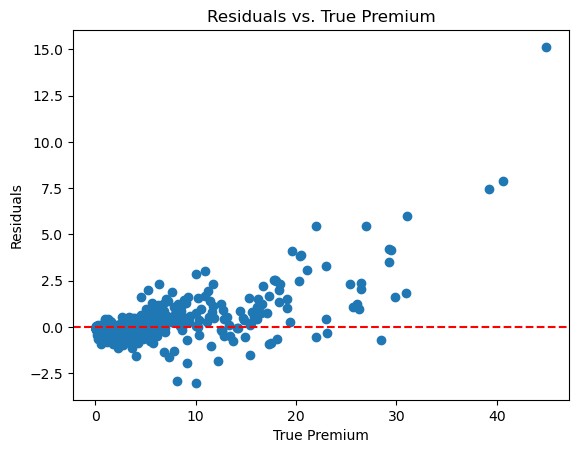

In [9]:
plt.scatter(np.expm1(y_test), residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True Premium")
plt.ylabel("Residuals")
plt.title("Residuals vs. True Premium")
plt.show()


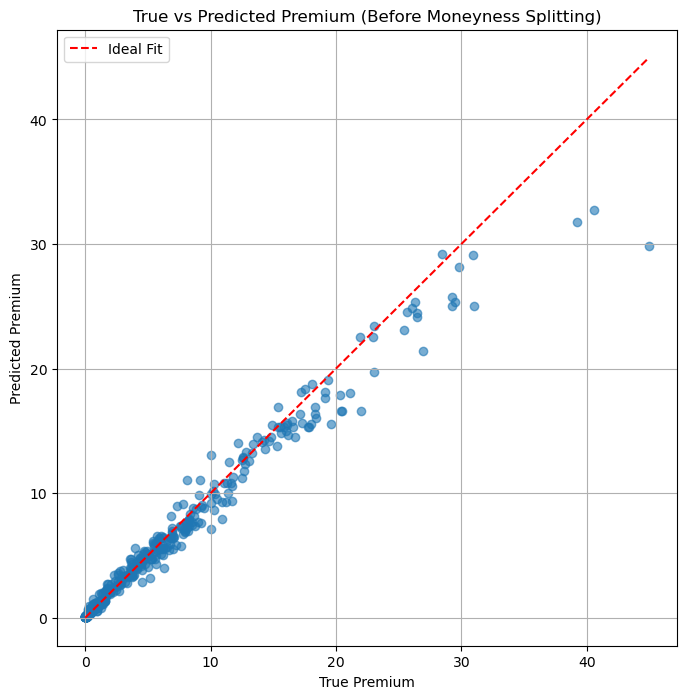

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_test), y_pred, alpha=0.6)
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], 
         [np.expm1(y_test).min(), np.expm1(y_test).max()], 
         color='red', linestyle='--', label="Ideal Fit")

plt.title("True vs Predicted Premium (Before Moneyness Splitting)")
plt.xlabel("True Premium")
plt.ylabel("Predicted Premium")
plt.legend()
plt.grid(True)
plt.show()

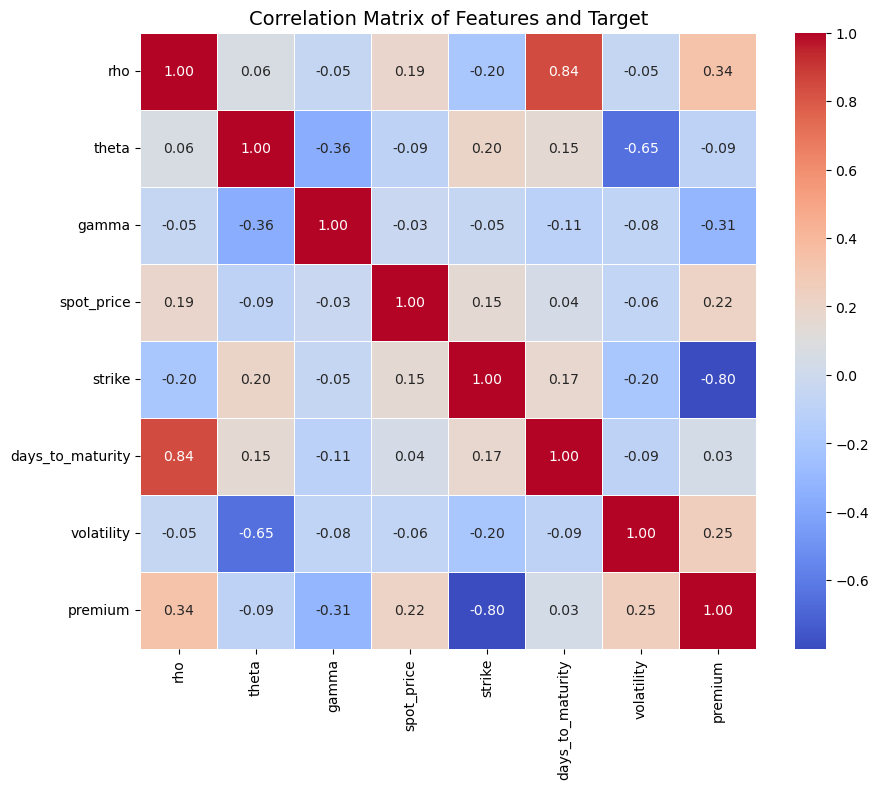

In [11]:
# Compute the correlation matrix
correlation_matrix = train_data[features + [target]].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.title("Correlation Matrix of Features and Target", fontsize=14)
plt.show()


In [12]:
# Split data based on moneyness


itm_options = european_calls[european_calls["moneyness"] == "ITM"]
atm_options = european_calls[european_calls["moneyness"] == "ATM"]
otm_options = european_calls[european_calls["moneyness"] == "OTM"]

# Train ITM Model
X_itm = itm_options[["strike", "days_to_maturity", "volatility"]]  # Feature columns
y_itm = itm_options["premium"]  # Target column
model_itm = xgb.XGBRegressor(max_depth=6, n_estimators=250, eta=0.2, random_state=42)
model_itm.fit(X_itm, y_itm)

# Train ATM Model
X_atm = atm_options[["strike", "days_to_maturity", "volatility"]]
y_atm = atm_options["premium"]
model_atm = xgb.XGBRegressor(max_depth=6, n_estimators=250, eta=0.2, random_state=42)
model_atm.fit(X_atm, y_atm)

# Train OTM Model
X_otm = otm_options[["strike", "days_to_maturity", "volatility"]]
y_otm = otm_options["premium"]
model_otm = xgb.XGBRegressor(max_depth=6, n_estimators=250, eta=0.2, random_state=42)
model_otm.fit(X_otm, y_otm)

# Split test data
itm_test = european_calls[european_calls["moneyness"] == "ITM"]
atm_test = european_calls[european_calls["moneyness"] == "ATM"]
otm_test = european_calls[european_calls["moneyness"] == "OTM"]

# Make predictions
itm_test["predicted_premium"] = model_itm.predict(itm_test[["strike", "days_to_maturity", "volatility"]])
atm_test["predicted_premium"] = model_atm.predict(atm_test[["strike", "days_to_maturity", "volatility"]])
otm_test["predicted_premium"] = model_otm.predict(otm_test[["strike", "days_to_maturity", "volatility"]])

# Combine all predictions
final_predictions = pd.concat([itm_test, atm_test, otm_test])

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# ITM Metrics
itm_mape = mean_absolute_percentage_error(itm_test["premium"], itm_test["predicted_premium"])
itm_mse = mean_squared_error(itm_test["premium"], itm_test["predicted_premium"])
itm_r2 = r2_score(itm_test["premium"], itm_test["predicted_premium"])
print(f"ITM - MAPE: {itm_mape:.2%}, MSE: {itm_mse:.4f}, RMSE: {np.sqrt(itm_mse):.4f}, R^2: {itm_r2:.4f}")

# ATM Metrics
atm_mape = mean_absolute_percentage_error(atm_test["premium"], atm_test["predicted_premium"])
atm_mse = mean_squared_error(atm_test["premium"], atm_test["predicted_premium"])
atm_r2 = r2_score(atm_test["premium"], atm_test["predicted_premium"])
print(f"ATM - MAPE: {atm_mape:.2%}, MSE: {atm_mse:.4f}, RMSE: {np.sqrt(atm_mse):.4f}, R^2: {atm_r2:.4f}")

# OTM Metrics
otm_mape = mean_absolute_percentage_error(otm_test["premium"], otm_test["predicted_premium"])
otm_mse = mean_squared_error(otm_test["premium"], otm_test["predicted_premium"])
otm_r2 = r2_score(otm_test["premium"], otm_test["predicted_premium"])
print(f"OTM - MAPE: {otm_mape:.4%}, MSE: {otm_mse:.4f}, RMSE: {np.sqrt(otm_mse):.4f}, R^2: {otm_r2:.4f}")


ITM - MAPE: 0.27%, MSE: 0.0023, RMSE: 0.0476, R^2: 1.0000
ATM - MAPE: 0.27%, MSE: 0.0002, RMSE: 0.0126, R^2: 1.0000
OTM - MAPE: 3.7501%, MSE: 0.0001, RMSE: 0.0113, R^2: 0.9999


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_27348\324378375.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itm_test["predicted_premium"] = model_itm.predict(itm_test[["strike", "days_to_maturity", "volatility"]])
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_27348\324378375.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atm_test["predicted_premium"] = model_atm.predict(atm_test[["strike", "days_to_maturity", "volatility"]])
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_27348\324378375.py:34: S

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, ...)

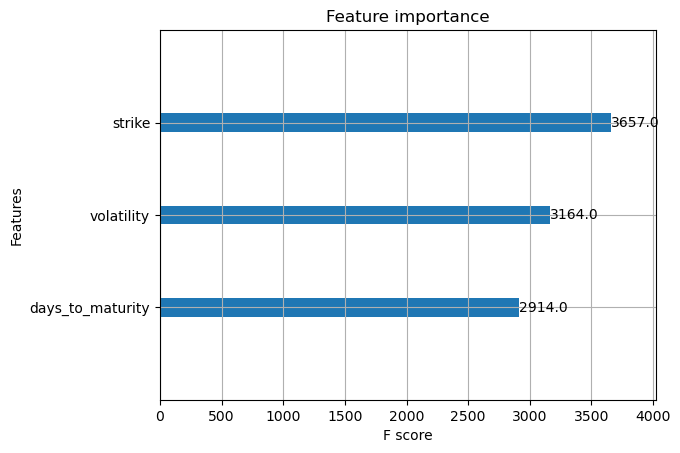

In [13]:
xgb.plot_importance(model_otm)
weights_otm = 1 / np.maximum(otm_options["premium"], 1e-3)  # Inverse of premium
model_otm.fit(X_otm, y_otm, sample_weight=weights_otm)


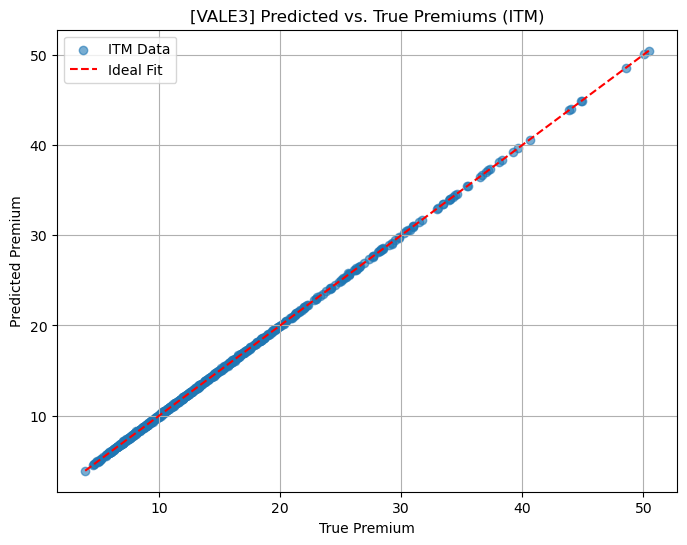

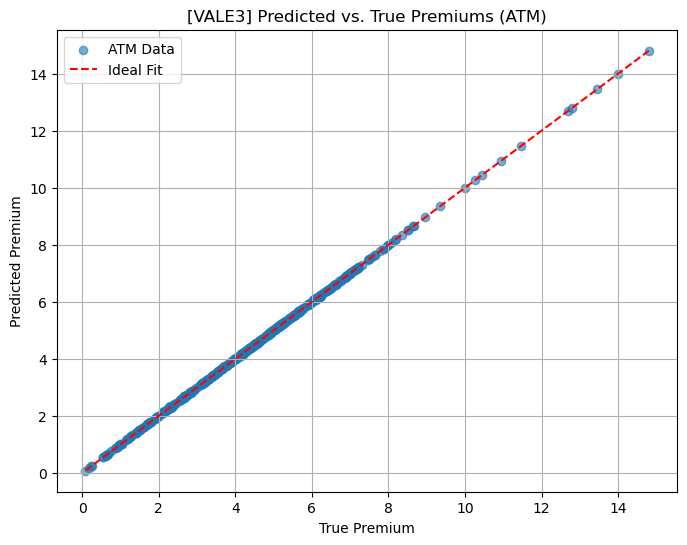

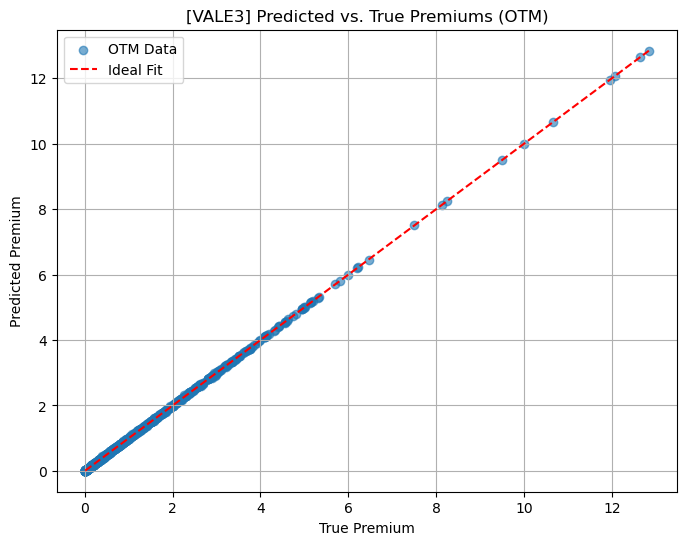

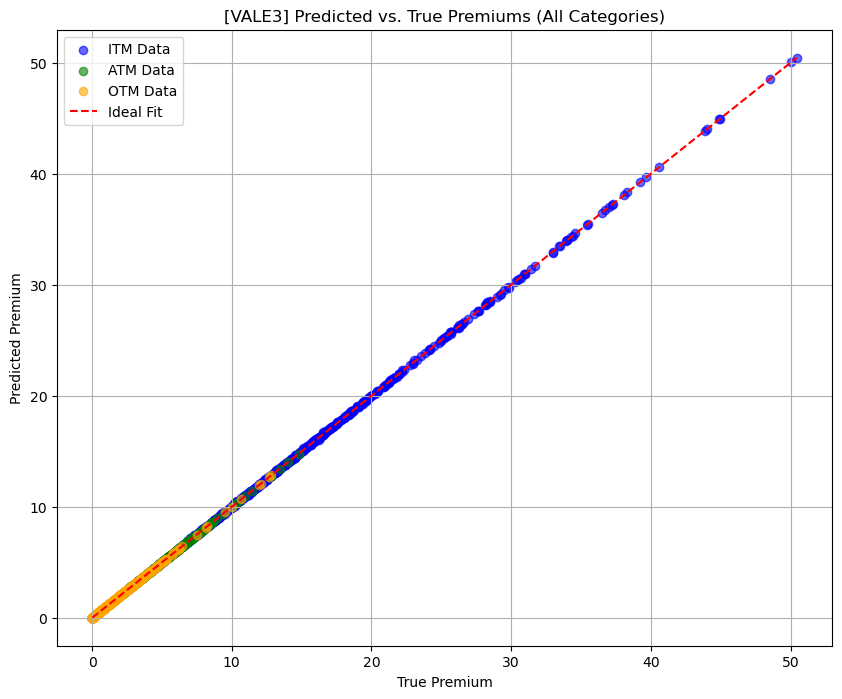

In [14]:
# Define a helper function to plot predicted vs true prices for each category
def plot_predicted_vs_true(data, category_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(data["premium"], data["predicted_premium"], alpha=0.6, label=f'{category_name} Data')
    plt.plot([data["premium"].min(), data["premium"].max()],
             [data["premium"].min(), data["premium"].max()],
             color='red', linestyle='--', label='Ideal Fit')
    plt.title(f"[VALE3] Predicted vs. True Premiums ({category_name})")
    plt.xlabel("True Premium")
    plt.ylabel("Predicted Premium")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot results for ITM, ATM, and OTM separately
plot_predicted_vs_true(itm_test, "ITM")
plot_predicted_vs_true(atm_test, "ATM")
plot_predicted_vs_true(otm_test, "OTM")

# Plot combined results for all moneyness categories
plt.figure(figsize=(10, 8))
plt.scatter(itm_test["premium"], itm_test["predicted_premium"], alpha=0.6, label='ITM Data', color='blue')
plt.scatter(atm_test["premium"], atm_test["predicted_premium"], alpha=0.6, label='ATM Data', color='green')
plt.scatter(otm_test["premium"], otm_test["predicted_premium"], alpha=0.6, label='OTM Data', color='orange')
plt.plot([final_predictions["premium"].min(), final_predictions["premium"].max()],
         [final_predictions["premium"].min(), final_predictions["premium"].max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title("[VALE3] Predicted vs. True Premiums (All Categories)")
plt.xlabel("True Premium")
plt.ylabel("Predicted Premium")
plt.legend()
plt.grid(True)
plt.show()
